In [64]:
import numpy as np
import pandas as pd
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import time
import re
import mlflow
import tensorflow as tf
from mlflow.models import infer_signature
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

2024/01/30 16:56:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [65]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [2]:
df = pd.read_csv("dataframe_final.csv")

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [3]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


In [4]:
# To start the mlflow server in local : mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Project7_LRnoSMOTE")

In [52]:
def calcul_metrics(model, X, y):
    """Fonction de calcul des metriques précision, AUC et score_metier en fonction du modèle en entrée. Retourne un dictionnaire."""
    metrics = {}
    
    accuracy = model.score(X, y)
    print(f'Précision : {accuracy:.2f}')
    metrics['accuracy'] = accuracy
    
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'AUC : {roc_auc:.2f}')
    metrics['roc_auc'] = roc_auc

    cf_matrix = confusion_matrix(y, model.predict(X))
    FN = cf_matrix[1,0]
    FP = cf_matrix[0,1]
    score_metier = 10*FN+FP
    print(f'Score métier : {score_metier}')
    metrics['score_metier'] = score_metier

    return metrics
    

In [74]:
def logToMLflow(model, X, metrics, params="", training_tag=""):
    # Start an MLflow run
    with mlflow.start_run():
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)
    
        # Log the loss metric
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])
        mlflow.log_metric("score_metier", metrics['score_metier'])
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)
    
        # Infer the model signature
        signature = infer_signature(X, model.predict(X))
    
        # Log the model
        mlflow.sklearn.log_model(model, 'model', signature=signature)
        
        """model_info = mlflow.sklearn.log_model(
            sk_model=lr,
            artifact_path="dataframe_final.csv",
            signature=signature,
            input_example=train_x,
            registered_model_name="lr-first",
        )"""

In [61]:
#Fonction prise dans le cours pour afficher les résultats d'un GridSearch.

def resultizeGrid(grid):
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    
    return res

# LOGISTIC REGRESSION

In [6]:
folds = KFold(n_splits=10, shuffle=True, random_state=1001)
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


In [7]:
from sklearn.impute import SimpleImputer

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

## Without SMOTE

Gestion des valeurs manquantes.

In [48]:
%%time

lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

metrics = calcul_metrics(lr, valid_x, valid_y)
print(classification_report(valid_y, lr.predict(valid_x)))

logToMLflow(lr, train_x, metrics, training_tag="Basic LR model no SMOTE no param")

Précision : 0.92
AUC : 0.53
Score métier : 24515
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     28297
         1.0       0.12      0.00      0.00      2453

    accuracy                           0.92     30750
   macro avg       0.52      0.50      0.48     30750
weighted avg       0.86      0.92      0.88     30750

CPU times: total: 2min 16s
Wall time: 19.3 s


<Axes: >

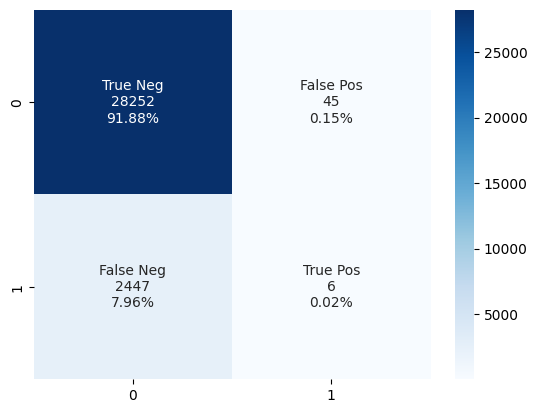

In [9]:
cf_matrix = confusion_matrix(valid_y, lr.predict(valid_x))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

## With SMOTE

In [68]:
%%time

params = {
    "model__C":np.logspace(-3, 3, 7)#,
    #"model__penalty":['l1', 'l2']
}

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
GS = GridSearchCV(pipeline, params, scoring='roc_auc')

GS.fit(train_x, train_y)

print("tuned hpyerparameters :(best parameters) ",GS.best_params_)
print("accuracy :",GS.best_score_)
resultizeGrid(GS)

tuned hpyerparameters :(best parameters)  {'model__C': 1.0}
accuracy : 0.5455892893428339
CPU times: total: 2h 5min 33s
Wall time: 17min 23s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,mean_test_score,std_test_score,rank_test_score
3,27.440255,0.576883,0.063846,0.001934,1.0,{'model__C': 1.0},0.545589,0.002383,1
1,28.957493,0.586720,0.064010,0.001669,0.01,{'model__C': 0.01},0.545252,0.002431,2
2,27.356862,1.033711,0.083898,0.042110,0.1,{'model__C': 0.1},0.545239,0.001672,3
4,26.795894,0.589767,0.062828,0.001007,10.0,{'model__C': 10.0},0.545115,0.001814,4
5,28.897548,1.172537,0.065416,0.002737,100.0,{'model__C': 100.0},0.545115,0.001814,4
6,30.917458,0.880646,0.090948,0.031255,1000.0,{'model__C': 1000.0},0.545115,0.001814,4
0,29.655802,2.043641,0.113709,0.100283,0.001,{'model__C': 0.001},0.544911,0.002312,7


In [75]:
%%time

metrics = calcul_metrics(GS.best_estimator_, valid_x, valid_y)
print(classification_report(valid_y, GS.best_estimator_.predict(valid_x)))

logToMLflow(GS.best_estimator_, train_x, metrics, params=GS.best_params_, training_tag="Basic LR model with SMOTE")

Précision : 0.80
AUC : 0.54
Score métier : 23932
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     28297
         1.0       0.10      0.19      0.13      2453

    accuracy                           0.80     30750
   macro avg       0.51      0.52      0.51     30750
weighted avg       0.86      0.80      0.83     30750

CPU times: total: 1.42 s
Wall time: 8.12 s


In [53]:
%%time

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)
print(classification_report(valid_y, pipeline.predict(valid_x)))

logToMLflow(lr, train_x, metrics, training_tag="Basic LR model with SMOTE no param")

Précision : 0.80
AUC : 0.54
Score métier : 23932
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     28297
         1.0       0.10      0.19      0.13      2453

    accuracy                           0.80     30750
   macro avg       0.51      0.52      0.51     30750
weighted avg       0.86      0.80      0.83     30750

CPU times: total: 4min 35s
Wall time: 38.3 s


<Axes: >

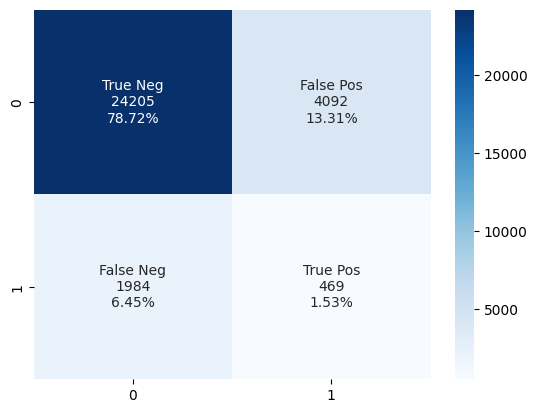

In [51]:
cf_matrix = confusion_matrix(valid_y, pipeline.predict(valid_x))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')